# Small CNN for traffic sign recognition as template for  assignment
## Christian Igel, 2020

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

In [0]:
# ## For reproducibility
# # import comet_ml in the top of your file
# from comet_ml import Experiment

# # Add the following code anywhere in your machine learning file
# experiment = Experiment(api_key="lmlmJiSHxoiyYYhUPNtlIIpL9",
#                         project_name="dropout", workspace="mahdi-robbani")

# # Run your code and go to https://www.comet.ml/

In [9]:
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import pathlib
import os

print("TensorFlow version:", tf.__version__)

AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow version: 2.2.0


In [0]:
seed_value = 420420
# #experiment.log_other("random seed", seed_value)

# # Set the seed value for all the frameworks
# os.environ['PYTHONHASHSEED']=str(seed_value)

# import random
# random.seed(seed_value)

# np.random.seed(seed_value)

# tf.random.set_seed(seed_value)

Download the data:

In [11]:
data_root="."
tf.keras.utils.get_file("GTSRB.zip",
                        "https://sid.erda.dk/share_redirect/EB0rrpZwuI",
                        cache_dir=data_root,
                        extract=True)


290897920/290897892 [==============================] - 3s 0us/step


'./datasets/GTSRB.zip'

The images are stored in subdirectories. The names of the subdirectories encode the class labels. 

In [12]:
# Determine the number of training and test images
n_train = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/train/*/*")))
n_test = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/test/*/*")))

print("Number of training images:", n_train)
print("Number of test images:" ,n_test)

Number of training images: 39209
Number of test images: 12630


Some basic constants: 

In [0]:
no_classes = 43  # There are 43 different signs
no_channels = 3  # We are dealing with color images

# All images are initially resized to img_height x img_width
img_height  = 32  
img_width   = 32
# During training and testing the  images are cropped to img_height_crop x img_width_crop
img_height_crop = 28  
img_width_crop  = 28

batch_size = 128
steps_per_epoch = n_train // batch_size  # How many batches are there in each epoch?

Helper function for extracting the label information from the paths to the images and loading and preprocessing the images:

In [0]:
# Extract the label from the file path
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.strings.to_number(parts[-2], tf.int32)

# Load image, convert it to floats, and resize it
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=no_channels)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])

# Given the path and filename of an image, create the label and the input image
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Create data sets based on the files:

In [0]:
# Tell dataset the lists of files containing the trainig and test images, respectively
list_ds_train = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/train/*/*")
list_ds_test  = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/test/*/*", shuffle=False)  # Fixed order for test time augemantation 

# Tell dataset how to extract images and labels
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

Functions for data preprocessing/augmentation:

In [0]:
# Used for training data augmentation
def augment(image, label):
    image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
    image = tf.case([(tf.equal(label, 11), lambda: tf.image.random_flip_left_right(image, seed_value)),
                     (tf.equal(label, 12), lambda: tf.image.random_flip_left_right(image, seed_value)),
                     (tf.equal(label, 13), lambda: tf.image.random_flip_left_right(image, seed_value)),
                     (tf.equal(label, 17), lambda: tf.image.random_flip_left_right(image, seed_value)),
                     (tf.equal(label, 18), lambda: tf.image.random_flip_left_right(image, seed_value)),
                     (tf.equal(label, 26), lambda: tf.image.random_flip_left_right(image, seed_value)),
                     (tf.equal(label, 30), lambda: tf.image.random_flip_left_right(image, seed_value)),
                     (tf.equal(label, 35), lambda: tf.image.random_flip_left_right(image, seed_value))], default = lambda: image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    #image = tf.image.random_contrast(image, lower=0.5, upper=2., seed=seed_value)
    image = tf.clip_by_value(image, 0., 1.)
    return image, label

# Used for testing/evaluation
def crop_center(image, label):
  image = tf.image.resize_with_crop_or_pad(image, img_height_crop, img_width_crop)
  return image, label

# Could be used for test time augementation
def crop_random(image, label):
  image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
  return image, label


We prepare the data for training and testing differently. For example, for training we use data augmentation.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # `.cache(filename)` is used to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):  # Is the chache argument a string?
      ds = ds.cache(cache)  # If yes, we cache to a file
    else:
      ds = ds.cache()  
  # We shuffle the data after the caching
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
  # Repeat forever
  ds = ds.repeat()
  # Do data augmentation
  ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_evaluation(ds, shuffle_buffer_size=1000):
  # For normal evaluation, we look at the center of the image
  ds = ds.map(crop_center, num_parallel_calls=AUTOTUNE)
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_augmented_evaluation(ds):
  ds = ds.map(crop_random, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

Let's have a look at a random batch of images:

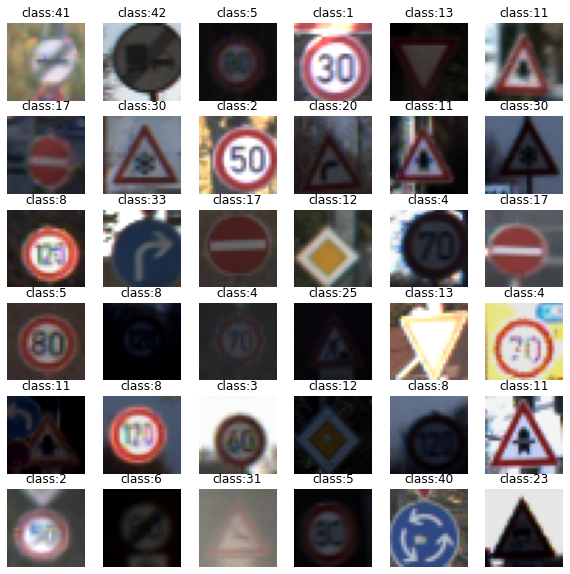

In [18]:
# Helper function for displaying images
def show_batch(image_batch, label_batch, nrows=6, ncols=6):
  plt.figure(figsize=(10,10))
  for n in range(nrows*ncols):
      ax = plt.subplot(nrows, ncols, n+1)
      if no_channels == 3:
        plt.imshow(image_batch[n])
      else:
        plt.imshow(image_batch[n].reshape([img_height_crop, img_width_crop]))
      plt.title('class:' + str(label_batch[n]))
      plt.axis('off')
# Make training dataset to retrieve some images
train_ds = prepare_for_training(labeled_ds_train)

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Visualize images and labels
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
eval_train_ds = prepare_for_evaluation(labeled_ds_train)
eval_test_ds = prepare_for_evaluation(labeled_ds_test)

In [0]:
tf.keras.backend.clear_session()  # clear previous layers

Define a neural network model:

In [21]:
sd_init = 0.01  # Standard deviation and offset for initializing bias parameters in hidden layers

default = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
                           input_shape=(img_width_crop, img_height_crop, 1),
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'default')
 
# dropout_1 = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
#                            input_shape=(img_width_crop, img_height_crop, no_channels),
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.Dropout(0.5, seed=seed_value), #added
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'drop1')

# dropout_1_pool = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
#                            input_shape=(img_width_crop, img_height_crop, no_channels),
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Dropout(0.5, seed=seed_value), #added
#     tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'drop1_pool')

# dropout_2 = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
#                            input_shape=(img_width_crop, img_height_crop, no_channels),
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.Dropout(0.5, seed=seed_value), #added
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.Dropout(0.5, seed=seed_value), #added
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'drop2')

# dropout_2_pool = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
#                            input_shape=(img_width_crop, img_height_crop, no_channels),
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Dropout(0.5, seed=seed_value), #added
#     tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Dropout(0.5, seed=seed_value), #added
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'drop2_pool')

# flatten = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
#                            input_shape=(img_width_crop, img_height_crop, no_channels),
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5, seed=seed_value), #added
#     tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'flatten')



# full_drop = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
#                            input_shape=(img_width_crop, img_height_crop, no_channels),
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'full_bn')

default.summary()
# dropout_1.summary()
# dropout_1_pool.summary()
# dropout_2.summary()
# dropout_2_pool.summary()
# flatten.summary()
#flatten.summary()
# full_bn.summary()

Model: "default"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
elu (ELU)                    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
elu_1 (ELU)                  (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0   

In [0]:
full = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
                           input_shape=(img_width_crop, img_height_crop, no_channels),
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5, seed=seed_value), #added
    tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5, seed=seed_value), #added
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5, seed=seed_value), #added
    tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'drop2_pool')
full.summary()
full.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "drop2_pool"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 32)        2432      
_________________________________________________________________
elu_12 (ELU)                 (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
elu_13 (ELU)                 (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 64)          0

In [0]:
full_02 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
                           input_shape=(img_width_crop, img_height_crop, no_channels),
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2, seed=seed_value), #added
    tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2, seed=seed_value), #added
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2, seed=seed_value), #added
    tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'drop2_pool')
full_02.summary()
full_02.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "drop2_pool"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 24, 24, 32)        2432      
_________________________________________________________________
elu_14 (ELU)                 (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
elu_15 (ELU)                 (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 64)          0

In [0]:
full_08 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
                           input_shape=(img_width_crop, img_height_crop, no_channels),
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.8, seed=seed_value), #added
    tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.8, seed=seed_value), #added
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8, seed=seed_value), #added
    tf.keras.layers.Dense(no_classes, activation='softmax')], name = 'drop2_pool')
full_08.summary()
full_08.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "drop2_pool"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 24, 24, 32)        2432      
_________________________________________________________________
elu_16 (ELU)                 (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
elu_17 (ELU)                 (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 64)          0

In [0]:
full_02_def = full_02.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 11ms/step - loss: 3.4302 - accuracy: 0.1118
Epoch 2/800
306/306 [==============================] - 2s 6ms/step - loss: 2.9155 - accuracy: 0.2522
Epoch 3/800
306/306 [==============================] - 2s 6ms/step - loss: 2.4920 - accuracy: 0.3229
Epoch 4/800
306/306 [==============================] - 2s 6ms/step - loss: 2.1903 - accuracy: 0.3907
Epoch 5/800
306/306 [==============================] - 2s 6ms/step - loss: 1.9299 - accuracy: 0.4512
Epoch 6/800
306/306 [==============================] - 2s 7ms/step - loss: 1.7106 - accuracy: 0.5104
Epoch 7/800
306/306 [==============================] - 2s 6ms/step - loss: 1.5186 - accuracy: 0.5646
Epoch 8/800
306/306 [==============================] - 2s 7ms/step - loss: 1.3617 - accuracy: 0.6098
Epoch 9/800
306/306 [==============================] - 2s 7ms/step - loss: 1.2270 - accuracy: 0.6493
Epoch 10/800
306/306 [==============================] - 2s 7ms/step - 

In [0]:
full_08_def = full_08.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 10ms/step - loss: 3.8392 - accuracy: 0.0931
Epoch 2/800
306/306 [==============================] - 2s 7ms/step - loss: 3.1102 - accuracy: 0.1945
Epoch 3/800
306/306 [==============================] - 2s 7ms/step - loss: 2.7972 - accuracy: 0.2599
Epoch 4/800
306/306 [==============================] - 2s 7ms/step - loss: 2.5666 - accuracy: 0.3070
Epoch 5/800
306/306 [==============================] - 2s 7ms/step - loss: 2.3868 - accuracy: 0.3439
Epoch 6/800
306/306 [==============================] - 2s 7ms/step - loss: 2.2409 - accuracy: 0.3752
Epoch 7/800
306/306 [==============================] - 2s 7ms/step - loss: 2.1047 - accuracy: 0.4063
Epoch 8/800
306/306 [==============================] - 2s 7ms/step - loss: 1.9988 - accuracy: 0.4301
Epoch 9/800
306/306 [==============================] - 2s 7ms/step - loss: 1.9055 - accuracy: 0.4520
Epoch 10/800
306/306 [==============================] - 2s 7ms/step - 

In [0]:
full_def = full.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 9ms/step - loss: 3.3899 - accuracy: 0.1250
Epoch 2/800
306/306 [==============================] - 2s 6ms/step - loss: 2.8021 - accuracy: 0.2510
Epoch 3/800
306/306 [==============================] - 2s 6ms/step - loss: 2.4088 - accuracy: 0.3404
Epoch 4/800
306/306 [==============================] - 2s 6ms/step - loss: 2.0865 - accuracy: 0.4143
Epoch 5/800
306/306 [==============================] - 2s 6ms/step - loss: 1.8441 - accuracy: 0.4722
Epoch 6/800
306/306 [==============================] - 2s 6ms/step - loss: 1.6520 - accuracy: 0.5256
Epoch 7/800
306/306 [==============================] - 2s 7ms/step - loss: 1.5013 - accuracy: 0.5665
Epoch 8/800
306/306 [==============================] - 2s 7ms/step - loss: 1.3623 - accuracy: 0.6073
Epoch 9/800
306/306 [==============================] - 2s 7ms/step - loss: 1.2598 - accuracy: 0.6370
Epoch 10/800
306/306 [==============================] - 2s 7ms/step - l

In [0]:
# ex_2_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
#                            input_shape=(img_width_crop, img_height_crop, no_channels),
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
#                            bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ELU(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(no_classes, activation='softmax')], name = '2_norm')

# ex_2_model.summary()

Define optimizer and compile the model:

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
default.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
dropout_1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
dropout_1_pool.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
dropout_2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
dropout_2_pool.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
flatten.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Do the learning:

In [0]:
history_def = default.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train for 306 steps
Epoch 1/800


COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


306/306 [==============================] - 15s 49ms/step - loss: 3.5978 - accuracy: 0.0588
Epoch 2/800
306/306 [==============================] - 2s 7ms/step - loss: 3.4188 - accuracy: 0.1325
Epoch 3/800
306/306 [==============================] - 2s 6ms/step - loss: 3.1671 - accuracy: 0.2245
Epoch 4/800
306/306 [==============================] - 2s 6ms/step - loss: 2.6944 - accuracy: 0.3166
Epoch 5/800
306/306 [==============================] - 2s 7ms/step - loss: 2.2612 - accuracy: 0.3952
Epoch 6/800
306/306 [==============================] - 2s 7ms/step - loss: 1.9296 - accuracy: 0.4718
Epoch 7/800
306/306 [==============================] - 2s 7ms/step - loss: 1.6774 - accuracy: 0.5388
Epoch 8/800
306/306 [==============================] - 2s 7ms/step - loss: 1.4757 - accuracy: 0.5969
Epoch 9/800
306/306 [==============================] - 2s 7ms/step - loss: 1.3273 - accuracy: 0.6416
Epoch 10/800
306/306 [==============================] - 2s 7ms/step - loss: 1.1929 - accuracy: 0.6786

In [0]:
history_dropout_1 = dropout_1.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

COMET WARNING: Set model graph by 'keras' ignored; already called. Future attempts are silently ignored.


Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 10ms/step - loss: 3.3753 - accuracy: 0.1432
Epoch 2/800
306/306 [==============================] - 2s 8ms/step - loss: 2.6530 - accuracy: 0.3142
Epoch 3/800
306/306 [==============================] - 2s 7ms/step - loss: 2.0886 - accuracy: 0.4215
Epoch 4/800
306/306 [==============================] - 2s 8ms/step - loss: 1.7460 - accuracy: 0.5065
Epoch 5/800
306/306 [==============================] - 2s 8ms/step - loss: 1.5073 - accuracy: 0.5773
Epoch 6/800
306/306 [==============================] - 2s 7ms/step - loss: 1.3169 - accuracy: 0.6339
Epoch 7/800
306/306 [==============================] - 2s 7ms/step - loss: 1.1616 - accuracy: 0.6761
Epoch 8/800
306/306 [==============================] - 2s 7ms/step - loss: 1.0429 - accuracy: 0.7165
Epoch 9/800
306/306 [==============================] - 2s 8ms/step - loss: 0.9318 - accuracy: 0.7501
Epoch 10/800
306/306 [==============================] - 2s 8ms/step - 

In [0]:
history_dropout_1_pool = dropout_1_pool.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 10ms/step - loss: 3.4790 - accuracy: 0.0990
Epoch 2/800
306/306 [==============================] - 2s 8ms/step - loss: 3.1084 - accuracy: 0.2141
Epoch 3/800
306/306 [==============================] - 2s 8ms/step - loss: 2.6580 - accuracy: 0.3010
Epoch 4/800
306/306 [==============================] - 3s 8ms/step - loss: 2.3174 - accuracy: 0.3624
Epoch 5/800
306/306 [==============================] - 3s 8ms/step - loss: 2.0579 - accuracy: 0.4226
Epoch 6/800
306/306 [==============================] - 3s 8ms/step - loss: 1.8348 - accuracy: 0.4790
Epoch 7/800
306/306 [==============================] - 2s 8ms/step - loss: 1.6460 - accuracy: 0.5330
Epoch 8/800
306/306 [==============================] - 3s 10ms/step - loss: 1.4831 - accuracy: 0.5787
Epoch 9/800
306/306 [==============================] - 3s 9ms/step - loss: 1.3528 - accuracy: 0.6177
Epoch 10/800
306/306 [==============================] - 3s 9ms/step -

In [0]:
history_dropout_2 = dropout_2.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 10ms/step - loss: 3.3007 - accuracy: 0.1498
Epoch 2/800
306/306 [==============================] - 2s 8ms/step - loss: 2.4932 - accuracy: 0.3218
Epoch 3/800
306/306 [==============================] - 3s 9ms/step - loss: 2.0085 - accuracy: 0.4350
Epoch 4/800
306/306 [==============================] - 3s 8ms/step - loss: 1.6603 - accuracy: 0.5226
Epoch 5/800
306/306 [==============================] - 3s 8ms/step - loss: 1.4228 - accuracy: 0.5898
Epoch 6/800
306/306 [==============================] - 3s 9ms/step - loss: 1.2359 - accuracy: 0.6455
Epoch 7/800
306/306 [==============================] - 3s 8ms/step - loss: 1.1014 - accuracy: 0.6833
Epoch 8/800
306/306 [==============================] - 3s 8ms/step - loss: 0.9921 - accuracy: 0.7136
Epoch 9/800
306/306 [==============================] - 3s 8ms/step - loss: 0.9006 - accuracy: 0.7390
Epoch 10/800
306/306 [==============================] - 3s 8ms/step - 

In [0]:
history_dropout_2_pool = dropout_2_pool.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 10ms/step - loss: 3.5160 - accuracy: 0.0899
Epoch 2/800
306/306 [==============================] - 2s 7ms/step - loss: 3.1462 - accuracy: 0.1905
Epoch 3/800
306/306 [==============================] - 2s 7ms/step - loss: 2.8054 - accuracy: 0.2552
Epoch 4/800
306/306 [==============================] - 2s 8ms/step - loss: 2.5284 - accuracy: 0.3156
Epoch 5/800
306/306 [==============================] - 2s 8ms/step - loss: 2.2851 - accuracy: 0.3708
Epoch 6/800
306/306 [==============================] - 2s 8ms/step - loss: 2.0826 - accuracy: 0.4148
Epoch 7/800
306/306 [==============================] - 3s 8ms/step - loss: 1.8968 - accuracy: 0.4557
Epoch 8/800
306/306 [==============================] - 2s 8ms/step - loss: 1.7351 - accuracy: 0.5001
Epoch 9/800
306/306 [==============================] - 2s 8ms/step - loss: 1.6094 - accuracy: 0.5308
Epoch 10/800
306/306 [==============================] - 2s 8ms/step - 

In [0]:
history_flatten = flatten.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

Train for 306 steps
Epoch 1/800
306/306 [==============================] - 3s 11ms/step - loss: 3.5081 - accuracy: 0.0900
Epoch 2/800
306/306 [==============================] - 2s 8ms/step - loss: 3.1318 - accuracy: 0.2064
Epoch 3/800
306/306 [==============================] - 2s 8ms/step - loss: 2.7123 - accuracy: 0.2839
Epoch 4/800
306/306 [==============================] - 2s 8ms/step - loss: 2.4166 - accuracy: 0.3411
Epoch 5/800
306/306 [==============================] - 2s 7ms/step - loss: 2.1620 - accuracy: 0.4001
Epoch 6/800
306/306 [==============================] - 2s 7ms/step - loss: 1.9541 - accuracy: 0.4482
Epoch 7/800
306/306 [==============================] - 2s 7ms/step - loss: 1.7671 - accuracy: 0.4960
Epoch 8/800
306/306 [==============================] - 2s 7ms/step - loss: 1.6143 - accuracy: 0.5365
Epoch 9/800
306/306 [==============================] - 2s 7ms/step - loss: 1.4937 - accuracy: 0.5708
Epoch 10/800
306/306 [==============================] - 2s 7ms/step - 

Let's evaluate the model:

In [0]:
print('Default')
results_def = default.evaluate(eval_train_ds)
print('Train loss, train acc:', results_def)
results_def = default.evaluate(eval_test_ds)
print('Test loss, test acc:', results_def)

Default
307/307 [==============================] - 15s 48ms/step - loss: 0.0016 - accuracy: 0.9999
Train loss, train acc: [0.001566491396003232, 0.9998725]
99/99 [==============================] - 5s 50ms/step - loss: 0.6675 - accuracy: 0.9377
Test loss, test acc: [0.6674677371103752, 0.93768805]


In [0]:
print('Dropout 1')
results_dropout1 = dropout_1.evaluate(eval_train_ds)
print('Train loss, train acc:', results_dropout1)
results_dropout1 = dropout_1.evaluate(eval_test_ds)
print('Test loss, test acc:', results_dropout1)

Dropout 1
307/307 [==============================] - 10s 31ms/step - loss: 0.0098 - accuracy: 0.99800s - loss: 0.0097 - accuracy
Train loss, train acc: [0.00975387370295774, 0.9979597]
99/99 [==============================] - 3s 31ms/step - loss: 0.3538 - accuracy: 0.9416
Test loss, test acc: [0.3538233751399578, 0.9416469]


In [0]:
print('Dropout 1 pool')
results_dropout_1_pool = dropout_1_pool.evaluate(eval_train_ds)
print('Train loss, train acc:', results_dropout_1_pool)
results_dropout_1_pool = dropout_1_pool.evaluate(eval_test_ds)
print('Test loss, test acc:', results_dropout_1_pool)

Dropout 1 pool
307/307 [==============================] - 10s 33ms/step - loss: 0.0016 - accuracy: 0.9997
Train loss, train acc: [0.0016063192681493223, 0.99974495]
99/99 [==============================] - 3s 32ms/step - loss: 0.2776 - accuracy: 0.9593
Test loss, test acc: [0.2775751282395635, 0.95930326]


In [0]:
print('Dropout 2')
results_dropout_2 = dropout_2.evaluate(eval_train_ds)
print('Train loss, train acc:', results_dropout_2)
results_dropout_2 = dropout_2.evaluate(eval_test_ds)
print('Test loss, test acc:', results_dropout_2)

Dropout 2
307/307 [==============================] - 10s 34ms/step - loss: 0.0374 - accuracy: 0.9912
Train loss, train acc: [0.03739098945847964, 0.9912265]
99/99 [==============================] - 3s 33ms/step - loss: 0.2624 - accuracy: 0.9397
Test loss, test acc: [0.2623797755117303, 0.93966746]


In [0]:
print('Dropout 2 pool')
results_dropout_2_pool = dropout_2_pool.evaluate(eval_train_ds)
print('Train loss, train acc:', results_dropout_2_pool)
results_dropout_2_pool = dropout_2_pool.evaluate(eval_test_ds)
print('Test loss, test acc:', results_dropout_2_pool)

Dropout 2 pool
307/307 [==============================] - 10s 34ms/step - loss: 0.0043 - accuracy: 0.9993
Train loss, train acc: [0.004311687752232107, 0.9993369]
99/99 [==============================] - 3s 34ms/step - loss: 0.1084 - accuracy: 0.9772
Test loss, test acc: [0.10835907142278862, 0.9771972]


In [0]:
print('Flatten')
results_flatten = flatten.evaluate(eval_train_ds)
print('Train loss, train acc:', results_flatten)
results_flatten = flatten.evaluate(eval_test_ds)
print('Test loss, test acc:', results_flatten)

Flatten
307/307 [==============================] - 10s 32ms/step - loss: 0.0018 - accuracy: 0.9998
Train loss, train acc: [0.0017903500362608433, 0.99977046]
99/99 [==============================] - 3s 31ms/step - loss: 0.1427 - accuracy: 0.9726
Test loss, test acc: [0.1426776872418013, 0.97260493]


In [0]:
print('Full')
results_full = full.evaluate(eval_train_ds)
print('Train loss, train acc:', results_full)
results_full = full.evaluate(eval_test_ds)
print('Test loss, test acc:', results_full)

Full
307/307 [==============================] - 10s 33ms/step - loss: 0.0185 - accuracy: 0.9992
Train loss, train acc: [0.018486136746523045, 0.9991584]
99/99 [==============================] - 3s 32ms/step - loss: 0.0814 - accuracy: 0.9824
Test loss, test acc: [0.08141561871543856, 0.9824228]


In [0]:
print('0.2')
results_full_02 = full_02.evaluate(eval_train_ds)
print('Train loss, train acc:', results_full_02)
results_full_02 = full_02.evaluate(eval_test_ds)
print('Test loss, test acc:', results_full_02)

0.2
307/307 [==============================] - 10s 34ms/step - loss: 0.0020 - accuracy: 0.9999
Train loss, train acc: [0.002014248084349153, 0.99989796]
99/99 [==============================] - 3s 33ms/step - loss: 0.1491 - accuracy: 0.9651
Test loss, test acc: [0.149057967648277, 0.9650831]


In [0]:
print('0.8')
results_full_08 = full_08.evaluate(eval_train_ds)
print('Train loss, train acc:', results_full_08)
results_full_08 = full_08.evaluate(eval_test_ds)
print('Test loss, test acc:', results_full_08)

0.8
307/307 [==============================] - 10s 34ms/step - loss: 0.8474 - accuracy: 0.8834
Train loss, train acc: [0.8474253936388594, 0.88341963]
99/99 [==============================] - 3s 34ms/step - loss: 0.9244 - accuracy: 0.8385
Test loss, test acc: [0.924398736896539, 0.8384798]


In [0]:
#dropout accuracy
#     Default
# 307/307 [==============================] - 15s 48ms/step - loss: 0.0016 - accuracy: 0.9999
# Train loss, train acc: [0.001566491396003232, 0.9998725]
# 99/99 [==============================] - 5s 50ms/step - loss: 0.6675 - accuracy: 0.9377
# Test loss, test acc: [0.6674677371103752, 0.93768805]
#     Flatten
# 307/307 [==============================] - 10s 32ms/step - loss: 0.0018 - accuracy: 0.9998
# Train loss, train acc: [0.0017903500362608433, 0.99977046]
# 99/99 [==============================] - 3s 31ms/step - loss: 0.1427 - accuracy: 0.9726
# Test loss, test acc: [0.1426776872418013, 0.97260493]
#     Dropout 1
# 307/307 [==============================] - 10s 31ms/step - loss: 0.0098 - accuracy: 0.99800s - loss: 0.0097 - accuracy
# Train loss, train acc: [0.00975387370295774, 0.9979597]
# 99/99 [==============================] - 3s 31ms/step - loss: 0.3538 - accuracy: 0.9416
# Test loss, test acc: [0.3538233751399578, 0.9416469]
#     Dropout 1 pool
# 307/307 [==============================] - 10s 33ms/step - loss: 0.0016 - accuracy: 0.9997
# Train loss, train acc: [0.0016063192681493223, 0.99974495]
# 99/99 [==============================] - 3s 32ms/step - loss: 0.2776 - accuracy: 0.9593
# Test loss, test acc: [0.2775751282395635, 0.95930326]
#     Dropout 2
# 307/307 [==============================] - 10s 34ms/step - loss: 0.0374 - accuracy: 0.9912
# Train loss, train acc: [0.03739098945847964, 0.9912265]
# 99/99 [==============================] - 3s 33ms/step - loss: 0.2624 - accuracy: 0.9397
# Test loss, test acc: [0.2623797755117303, 0.93966746]
#     Dropout 2 pool
# 307/307 [==============================] - 10s 34ms/step - loss: 0.0043 - accuracy: 0.9993
# Train loss, train acc: [0.004311687752232107, 0.9993369]
# 99/99 [==============================] - 3s 34ms/step - loss: 0.1084 - accuracy: 0.9772
# Test loss, test acc: [0.10835907142278862, 0.9771972]
#Full
# 307/307 [==============================] - 10s 33ms/step - loss: 0.0185 - accuracy: 0.9992
# Train loss, train acc: [0.018486136746523045, 0.9991584]
# 99/99 [==============================] - 3s 32ms/step - loss: 0.0814 - accuracy: 0.9824
# Test loss, test acc: [0.08141561871543856, 0.9824228]

In [0]:
# Default
# Average test accuracy: 0.9377
# Flatten
# Average test accuracy: 0.9726
# Dropout 1
# Average test accuracy: 0.9416
# Dropout 1 pool
# Average test accuracy: 0.9593
# Dropout 2
# Average test accuracy: 0.9397
# Dropout 2 pool
# Average test accuracy: 0.9772
# Dropout 3
# Average test accuracy: 0.9824

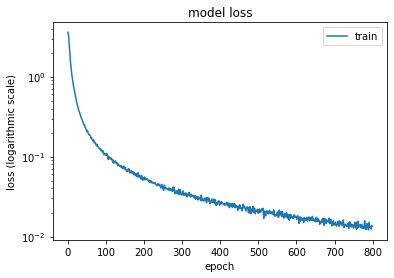

In [0]:
history_def.history.keys()
# Summarize history for loss
plt.plot(history_def.history['loss'])
plt.title('model loss')
plt.ylabel('loss (logarithmic scale)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

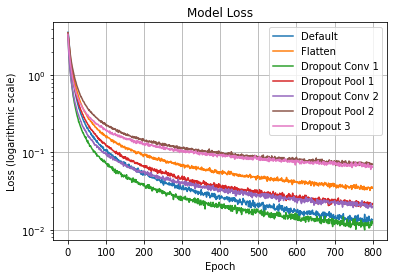

In [0]:
history_6 = []
history_6.append(history_def.history['loss'])
history_6.append(history_flatten.history['loss'])
history_6.append(history_dropout_1.history['loss'])
history_6.append(history_dropout_1_pool.history['loss'])
history_6.append(history_dropout_2.history['loss'])
history_6.append(history_dropout_2_pool.history['loss'])
history_6.append(full_def.history['loss'])
# history_6.append(full_02_def.history['loss'])
# history_6.append(full_08_def.history['loss'])

leg = ['Default', "Flatten", 'Dropout Conv 1', 'Dropout Pool 1', 'Dropout Conv 2', 'Dropout Pool 2', 'Dropout 3']

for i in history_6:
    plt.plot(i)
    plt.legend(leg)
    plt.yscale('log')
    plt.ylabel('Loss (logarithmic scale)')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.title('Model Loss')
plt.savefig('Loss', dpi=200)

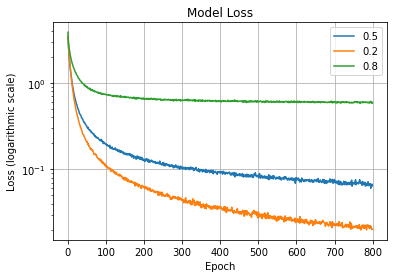

In [0]:
history_6 = []
history_6.append(full_def.history['loss'])
history_6.append(full_02_def.history['loss'])
history_6.append(full_08_def.history['loss'])

leg = [0.5, 0.2, 0.8]

for i in history_6:
    plt.plot(i)
    plt.legend(leg)
    plt.yscale('log')
    plt.ylabel('Loss (logarithmic scale)')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.title('Model Loss')
plt.savefig('Loss2', dpi=200)

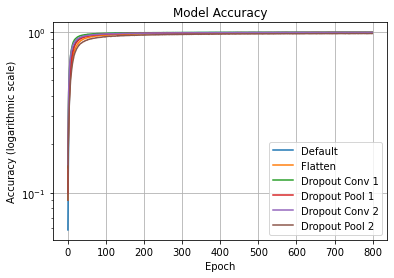

In [0]:
history_6 = []
history_6.append(history_def.history['accuracy'])
history_6.append(history_flatten.history['accuracy'])
history_6.append(history_dropout_1.history['accuracy'])
history_6.append(history_dropout_1_pool.history['accuracy'])
history_6.append(history_dropout_2.history['accuracy'])
history_6.append(history_dropout_2_pool.history['accuracy'])
history_6.append(full_def.history['accuracy'])

leg = ['Default', "Flatten", 'Dropout Conv 1', 'Dropout Pool 1', 'Dropout Conv 2', 'Dropout Pool 2', 'Dropout 3']

for i in history_6:
    plt.plot(i)
    plt.legend(leg)
    plt.yscale('log')
    plt.ylabel('Accuracy (logarithmic scale)')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.title('Model Accuracy')

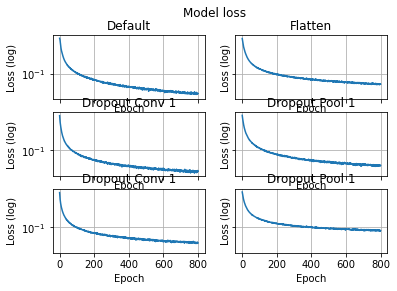

In [0]:
fig, axs = plt.subplots(3, 2, True, True)
fig.suptitle('Model loss')


axs[0, 0].plot(history_def.history['loss'])
axs[0, 0].set_title('Default')
axs[0, 1].plot(history_flatten.history['loss'])
axs[0, 1].set_title('Flatten')
axs[1, 0].plot(history_dropout_1.history['loss'])
axs[1, 0].set_title('Dropout Conv 1')
axs[1, 1].plot(history_dropout_1_pool.history['loss'])
axs[1, 1].set_title('Dropout Pool 1')
axs[2, 0].plot(history_dropout_2.history['loss'])
axs[2, 0].set_title('Dropout Conv 1')
axs[2, 1].plot(history_dropout_2_pool.history['loss'])
axs[2, 1].set_title('Dropout Pool 1')
plt.yscale('log')

for i in range(3):
    for j in range(2):
        axs[i,j].grid()
        
for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss (log)')
    
plt.savefig("test", dpi=200)
# plt.ylabel('loss (logarithmic scale)')
# plt.xlabel('epoch')
#
# plt.grid()

In [0]:
# print('Full Batch Norm')
# results_full = full_bn.evaluate(eval_train_ds)
# print('Train loss, train acc:', results_full)
# results_full = full_bn.evaluate(eval_test_ds)
# print('Test loss, test acc:', results_full)

There are lot of ways to improve the model above. According to Stallkamp et al. (2012), an ensemble of CNNs can reach 99.46%. Good human performance is 
99.22%.

In [0]:
##################################################################################
#Default 800 epochs
# 307/307 [==============================] - 14s 46ms/step - loss: 0.0015 - accuracy: 0.9999
# Train loss, train acc: [0.0015233905287459493, 0.9998725056648254]
# 99/99 [==============================] - 5s 46ms/step - loss: 0.5452 - accuracy: 0.9438
# Test loss, test acc: [0.5452429056167603, 0.9437846541404724]
# Default2
# 307/307 [==============================] - 9s 31ms/step - loss: 0.0018 - accuracy: 0.9997
# Train loss, train acc: [0.0018012200420438817, 0.99974495]
# 99/99 [==============================] - 3s 33ms/step - loss: 0.5617 - accuracy: 0.9439
# Test loss, test acc: [0.5616763661306285, 0.94394296]
############################################
#Added 1 batch normalization
# 307/307 [==============================] - 14s 46ms/step - loss: 4.0301e-04 - accuracy: 0.9999
# Train loss, train acc: [0.00040300810360349715, 0.9999489784240723]
# 99/99 [==============================] - 5s 48ms/step - loss: 0.2240 - accuracy: 0.9673
# Test loss, test acc: [0.22397276759147644, 0.9673000574111938]
#added 2 batch normalizations
# 307/307 [==============================] - 14s 45ms/step - loss: 7.8606e-04 - accuracy: 1.0000
# Train loss, train acc: [0.0007860587793402374, 0.9999744892120361]
# 99/99 [==============================] - 4s 45ms/step - loss: 0.1131 - accuracy: 0.9711
# Test loss, test acc: [0.11312877386808395, 0.9711005687713623]
# Flatten
# 307/307 [==============================] - 10s 32ms/step - loss: 0.0029 - accuracy: 0.9997
# Train loss, train acc: [0.002929576015928821, 0.99971944]
# 99/99 [==============================] - 3s 32ms/step - loss: 0.1021 - accuracy: 0.9707
# Test loss, test acc: [0.10209610829432024, 0.9707047]
# Full Batch Norm
# 307/307 [==============================] - 10s 32ms/step - loss: 0.0025 - accuracy: 0.9999
# Train loss, train acc: [0.0025113637571250384, 0.99992347]
# 99/99 [==============================] - 3s 32ms/step - loss: 0.1202 - accuracy: 0.9700
# Test loss, test acc: [0.12019359615776627, 0.9699921]
############################################ SEED 420420
# Default
# 307/307 [==============================] - 11s 35ms/step - loss: 0.0016 - accuracy: 0.9998
# Train loss, train acc: [0.0015631209864491197, 0.999796]
# 99/99 [==============================] - 3s 35ms/step - loss: 0.6310 - accuracy: 0.9377
# Test loss, test acc: [0.6310483102806067, 0.93768805]
# Flatten
# 307/307 [==============================] - 11s 35ms/step - loss: 0.0037 - accuracy: 0.9993
# Train loss, train acc: [0.003687807101701729, 0.9992859]
# 99/99 [==============================] - 3s 35ms/step - loss: 0.1222 - accuracy: 0.9662
# Test loss, test acc: [0.1222067772907045, 0.9661916]
# Full Batch Norm (ACTUALLY JUST FLATTEN)
# 307/307 [==============================] - 11s 34ms/step - loss: 0.0020 - accuracy: 0.9999
# Train loss, train acc: [0.0020417023547496557, 0.99989796]
# 99/99 [==============================] - 3s 34ms/step - loss: 0.0890 - accuracy: 0.9746
# Test loss, test acc: [0.08904708022123257, 0.97458434]
# Full Batch Norm (true)
# 307/307 [==============================] - 13s 41ms/step - loss: 0.0011 - accuracy: 1.0000
# Train loss, train acc: [0.001149165051672054, 1.0]
# 99/99 [==============================] - 4s 41ms/step - loss: 0.1173 - accuracy: 0.9694
# Test loss, test acc: [0.11727825616892942, 0.9693587]
